# CS4487 - Machine Learning
# Lecture 5b - Supervised Learning - Regression
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Linear Regression
2. Selecting Features
3. **Removing Outliers**
4. Non-linear regression

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Outliers
- Too many outliers in the data can affect the squared-error term.
  - regression function will try to reduce the large prediction error for outliers, at the expense of worse prediction for other points
  

In [2]:
linbias = 30
[linX, linY, lincoefs] = datasets.make_regression(n_samples=100, n_features=1, 
                                                  n_informative=1, bias=linbias, noise=5.0, 
                                                  coef=True, random_state=4487)
# outliers
outbias = 10
[outX, outY, outcoefs] = datasets.make_regression(n_samples=10, n_features=1, 
                                                  n_informative=1, bias=outbias, noise=5.0, 
                                                  coef=True, random_state=447)

# combine
outlinX = r_[linX, 2+outX/2]
outlinY = r_[linY, outY]

# fit using ordinary least squares
ols = linear_model.LinearRegression()
ols.fit(outlinX, outlinY)

# fit using ridge regression
alpha = 100
rr = linear_model.Ridge(alpha=alpha)
rr.fit(outlinX, outlinY)

axbox = [-3, 4, -40, 100]

xr = linspace(axbox[0], axbox[1], 100).reshape(100,1)
ypred = ols.predict(xr)
ypredrr = rr.predict(xr)

outfig = plt.figure()
plt.plot(outlinX, outlinY, 'b.')
l1, = plt.plot(xr, ypred, 'r-')
l2, = plt.plot(xr, ypredrr, 'm-')
plt.xlabel('feature x')
plt.ylabel('output y')
plt.grid(True); plt.axis(axbox)
leg = plt.legend((l1,l2), ('OLS','RR $\\alpha='+str(alpha)+'$'), loc='upper left')
leg.get_frame().set_facecolor('white')

plt.close()

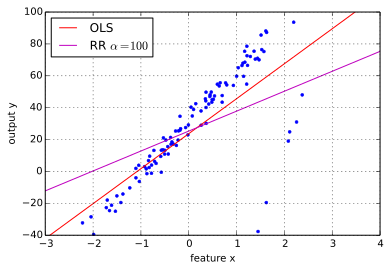

In [3]:
outfig

# RANSAC
- **RAN**dom **SA**mple **C**onsensus
  - attempt to robustly fit a regression model in the presence of corrupted data (outliers).
  - works with any regression model.
- **Idea:**
  - split the data into inliers (good data) and outliers (bad data).
  - learn the model only from the inliers

# Random sampling
- Repeat many times...
  - randomly sample a subset of points from the data. Typically just enough to learn the regression model
  - fit a model to the subset.
  - classify all data as inlier or outlier by calculating the residuals (prediction errors) and comparing to a threshold.  The set of inliers is called the _consensus set_.
  - save the model with the highest number of inliers.
- Finally, use the largest consensus set to learn the final model.

In [4]:

random.seed(1002)
ransacfig = plt.figure(figsize=(12,3))
for i in range(3):    
    inds = [random.choice(range(len(outlinY))) for j in range(2)]
    
    ols = linear_model.LinearRegression()
    ols.fit(outlinX[inds], outlinY[inds])

    ypred = ols.predict(xr)
    T = 15
    
    # calculate number of inliers
    ytpred = ols.predict(outlinX)
    numin = sum(abs(ytpred-outlinY)<=T)
    
    plt.subplot(1,3,i+1)
    plt.plot(outlinX, outlinY, 'b.')
    l0, = plt.plot(outlinX[inds], outlinY[inds], 'ro')
    l1, = plt.plot(xr, ypred, 'r-')
    l2, = plt.plot(xr, ypred+T, 'r--')
    l3, = plt.plot(xr, ypred-T, 'r--')
    plt.grid(True); plt.axis(axbox)
    plt.title("number of inliers = " + str(numin))
    if i==0:
        leg = plt.legend((l0,l1,l2), 
                     ('selected points', 'estimated line', 'inlier threshold'), 
                    fontsize=8, loc='upper left')
        leg.get_frame().set_facecolor('white')


plt.close()

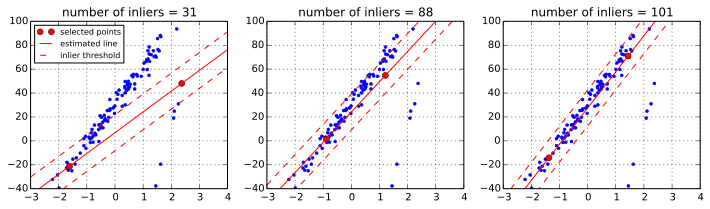

In [5]:
ransacfig

# RANSAC
- More iterations increases the probability of finding the correct function.
  - higher probability to select a subset of points contains all inliers.
- Threshold typically set as the median absolute deviation of $y$.

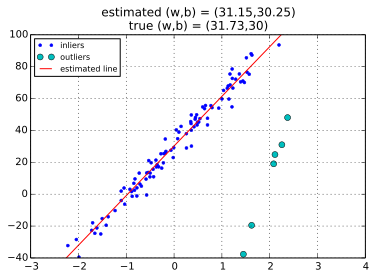

In [6]:
# use RANSAC model (defaults to linear regression)
rlin = linear_model.RANSACRegressor(random_state=1234)
rlin.fit(outlinX, outlinY)

inlier_mask = rlin.inlier_mask_
outlier_mask = logical_not(inlier_mask)

ypred = rlin.predict(xr)
    
l1, = plt.plot(outlinX[inlier_mask], outlinY[inlier_mask], 'b.')
l2, = plt.plot(outlinX[outlier_mask], outlinY[outlier_mask], 'co')
l3, = plt.plot(xr, ypred, 'r-')
leg = plt.legend((l1,l2,l3), ('inliers', 'outliers', 'estimated line'), 
                fontsize=8, loc='upper left')
leg.get_frame().set_facecolor('white')
plt.grid(True); plt.axis(axbox);
plt.title('estimated (w,b) = (%0.4g,%0.4g)\ntrue (w,b) = (%0.4g,%0.4g)' % 
          (rlin.estimator_.coef_, rlin.estimator_.intercept_, lincoefs, linbias));

# Non-linear regression
- So far we have only considered linear regression: $f(x) = w^Tx + b$
- Similar to classifcation, we can do non-linear regression by forming a feature vector of $x$ and then performing linear regression on the feature vector.

# Polynomial regression
- p-th order Polynomial function
  - $f(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \cdots + w_p x^p$
- Collect the terms into a vector
  - $f(x) = \begin{bmatrix}w_0 &w_1 &w_2 &\cdots &w_p\end{bmatrix}*\begin{bmatrix}1\\x\\x^2 \\\vdots\\x^p\end{bmatrix} = w^T \phi(x)$ 
  - weight vector $w = \begin{bmatrix}w_0 \\w_1 \\w_2 \\\vdots \\w_p\end{bmatrix}$; polynomial feature vector: $\phi(x) = \begin{bmatrix}1\\x\\x^2 \\\vdots\\x^p\end{bmatrix}$
- Now it's a linear function, so we can use the same linear regression!

# Example

- 1st to 6th order polynomials

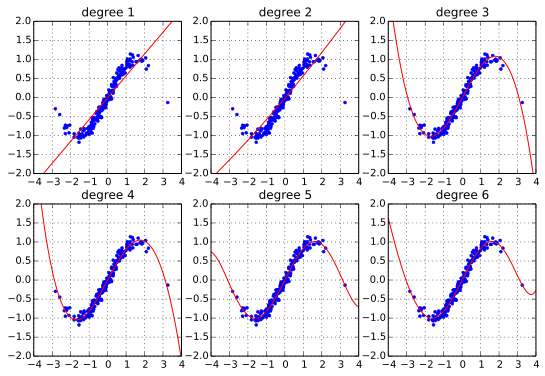

In [7]:
# example data
polyX = random.normal(size=200)
polyY = sin(polyX) + 0.1*random.normal(size=200)
polyX = polyX[:,newaxis]

plt.figure(figsize=(9,6))

axbox = [-4, 4, -2, 2]
xr = linspace(axbox[0], axbox[1], 100)

for d in [1,2,3,4,5,6]:
    # extract polynomial features with degree d
    polyfeats = preprocessing.PolynomialFeatures(degree=d)
    polyXf = polyfeats.fit_transform(polyX)

    # fit the parameters
    plin = linear_model.LinearRegression()
    plin.fit(polyXf, polyY)
    
    # predict the function
    xrf = polyfeats.transform(xr[:,newaxis])
    Ypred = plin.predict(xrf)
    
    plt.subplot(2,3,d)
    plt.plot(polyX, polyY, 'b.')
    plt.plot(xr, Ypred, 'r-')
    plt.axis(axbox); plt.grid(True)
    plt.title("degree " + str(d))

# Example: Boston data
- Using "percentage of lower-status" feature
- Increasing polynomial degree $d$ will decrease MSE of training data
  - more complicated model always fits data better
  - (but it could overfit)

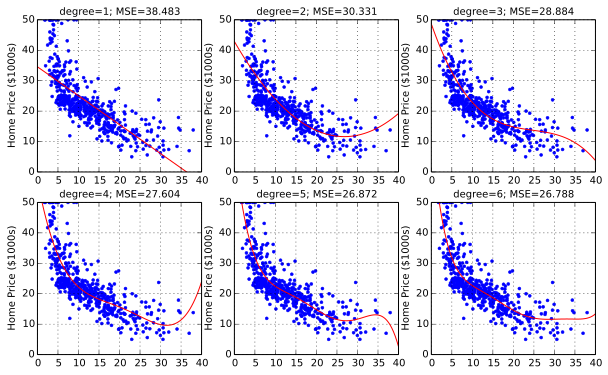

In [8]:
boston = datasets.load_boston()
bostonY = boston['target']
bostonX = boston['data'][:,12][:,newaxis]

bostonFeats = 'percent of low-status households'
bostonaxbox = [0,40,0,50]
xr = linspace(bostonaxbox[0], bostonaxbox[1], 100)

plt.figure(figsize=(10,6))

for d in [1,2,3,4,5,6]:
    # extract polynomial features with degree d
    polyfeats = preprocessing.PolynomialFeatures(degree=d)
    bostonXf = polyfeats.fit_transform(bostonX)

    # fit the parameters
    plin = linear_model.LinearRegression()
    plin.fit(bostonXf, bostonY)

    # calculate mean-square error on training set
    MSE = mean((plin.predict(bostonXf) - bostonY)**2)

    # predict the function
    xrf = polyfeats.transform(xr[:,newaxis])
    Ypred = plin.predict(xrf)
    
    plt.subplot(2,3,d)
    plt.plot(bostonX, bostonY, 'b.')
    plt.plot(xr, Ypred, 'r-')
    plt.ylabel('Home Price ($1000s)')
    #plt.xlabel(bostonFeats)    
    plt.axis(bostonaxbox)
    plt.grid(True)
    plt.title('degree=%d; MSE=%0.5g' % (d, MSE), fontsize=10)

# Select degree using Cross-Validation

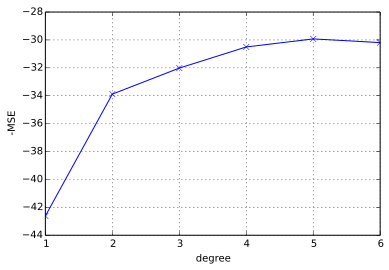

best d = 5


In [9]:
# degree values to use
ds = [1,2,3,4,5,6]
avgscores = empty(len(ds))

for i,d in enumerate(ds):
    # extract polynomial features with degree d
    polyfeats = preprocessing.PolynomialFeatures(degree=d)
    bostonXf = polyfeats.fit_transform(bostonX)

    # use cross-validation w/ mean-squared-error
    plin = linear_model.LinearRegression()
    myscore = cross_validation.cross_val_score(plin, bostonXf, bostonY, 
                                            cv=5, scoring='mean_squared_error')
    avgscores[i] = mean(myscore)

# plot avg score versus d
plt.figure()
plt.plot(ds, avgscores, 'bx-')
plt.xlabel('degree')
plt.ylabel('-MSE')
plt.grid(True)
plt.show()

# pick the best d
besti = argmax(avgscores)
bestd = ds[besti]
print "best d = " + str(bestd)


# Polynomial features: 2D Example
- 2D feature: $x = \begin{bmatrix}x_1 &x_2\end{bmatrix}^T$
- degree 2: $\phi(x) = \begin{bmatrix}x_1^2& x_1 x_2 & x_2^2\end{bmatrix}^T$
- degree 3: $\phi(x) = \begin{bmatrix}x_1^3& x_1^2 x_2 & x_1 x_2^2 & x_3^2\end{bmatrix}^T$

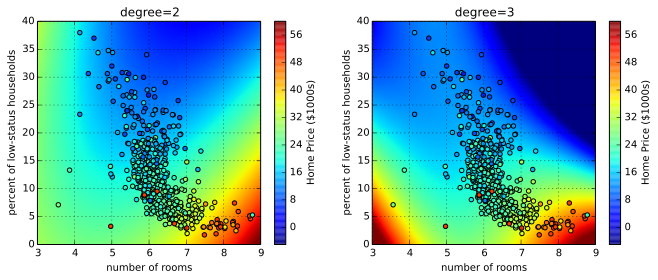

In [10]:
bostonFeats = ('number of rooms', 'percent of low-status households')
bostonaxbox = ([3,9,0,50], [0,40,0,50])
bostonaxbox2 = bostonaxbox[0][0:2] + bostonaxbox[1][0:2]

bostonY = boston['target']
bostonX = boston['data'][:,[5,12]]

plt.figure(figsize=(11,4))

for i,d in enumerate([2,3]):
    polyfeats = preprocessing.PolynomialFeatures(degree=d)
    bostonXf = polyfeats.fit_transform(bostonX)

    # learn with both dimensions
    plin = linear_model.LinearRegression()
    plin.fit(bostonXf, bostonY)

    # predict 
    xr = [linspace(bostonaxbox2[0],bostonaxbox2[1],100), 
          linspace(bostonaxbox2[2],bostonaxbox2[3],100)]
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]
    allptsf = polyfeats.fit_transform(allpts)

    ypred = plin.predict(allptsf).reshape(xgrid0.shape)

    # calculate MSE
    MSE = mean((plin.predict(bostonXf) - bostonY)**2)

    # make figure
    plt.subplot(1,2,i+1)
    vmin = bostonY.min()-10
    vmax = bostonY.max()+10
    plt.imshow(ypred, origin='lower', extent=bostonaxbox2, aspect='auto', 
               vmin=vmin, vmax=vmax)
    plt.scatter(bostonX[:,0], bostonX[:,1], c=bostonY, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar()
    cbar.set_label('Home Price ($1000s)')
    plt.xlabel('number of rooms')
    plt.ylabel('percent of low-status households')
    plt.grid(True); plt.axis(bostonaxbox2)
    plt.title('degree=%d' % (d,))

# Kernel Ridge Regression
- Apply _kernel trick_ to ridge regression
  - turn linear regression into non-linear regression

# Example: Polynomial Kernel
- Note: it's the same as using polynomial features and linear regression!
  - Using the kernel, we don't need to explicitly calculate the polynomial features.
  - But, we do need to calculate the kernel function between all pairs of training points.

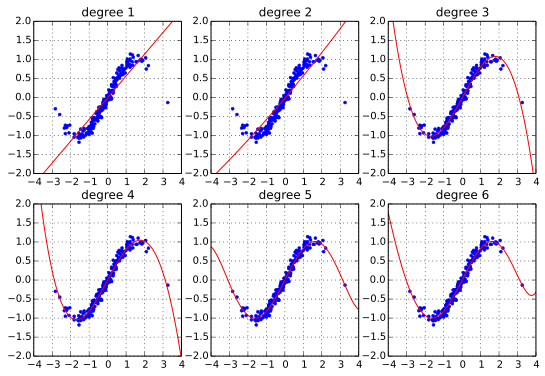

In [11]:
plt.figure(figsize=(9,6))

axbox = [-4, 4, -2, 2]
xr = linspace(axbox[0], axbox[1], 100)[:,newaxis]

for d in [1,2,3,4,5,6]:

    # fit the parameters
    krr = kernel_ridge.KernelRidge(alpha=1, kernel='poly', degree=d)
    krr.fit(polyX, polyY)
    
    # predict the function
    Ypred = krr.predict(xr)
    
    plt.subplot(2,3,d)
    plt.plot(polyX, polyY, 'b.')
    plt.plot(xr, Ypred, 'r-')
    plt.axis(axbox); plt.grid(True)
    plt.title("degree " + str(d))

# Example: RBF kernel
- gamma controls the smoothness
  - small gamma will etimate a smooth function
  - large gamma will estimate a wiggly function

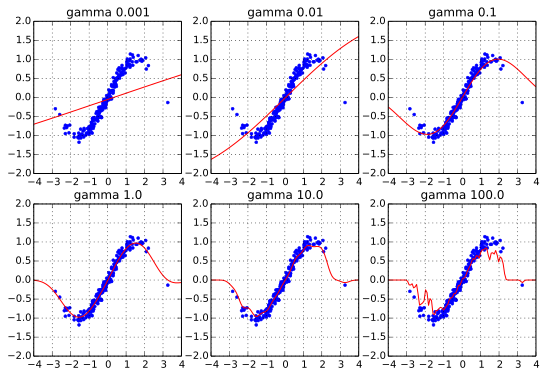

In [12]:
plt.figure(figsize=(9,6))

axbox = [-4, 4, -2, 2]
xr = linspace(axbox[0], axbox[1], 100)[:,newaxis]

for i,g in enumerate(logspace(-3,2,6)):
    # fit the parameters
    krr = kernel_ridge.KernelRidge(alpha=1, kernel='rbf', gamma=g)
    krr.fit(polyX, polyY)
    
    # predict the function
    Ypred = krr.predict(xr)
    
    plt.subplot(2,3,i+1)
    plt.plot(polyX, polyY, 'b.')
    plt.plot(xr, Ypred, 'r-')
    plt.axis(axbox); plt.grid(True)
    plt.title("gamma " + str(g))

# Boston Data: Cross-validation
- RBF kernel
  - cross-validation to select $\alpha$ and $\gamma$.

In [13]:
# parameters for cross-validation
params = {'alpha': logspace(-3,3,10),
          'gamma': logspace(-3,3,10)}

# do cross-validation with grid_search module.
krr = grid_search.GridSearchCV(
    kernel_ridge.KernelRidge(kernel='rbf'),  # estimator
    params,                                  # parameters to try
    scoring='mean_squared_error',          # score function
    cv=5)                               # number of folds
krr.fit(bostonX, bostonY)

print krr.best_score_
print krr.best_params_

-25.3336025803
{'alpha': 0.0046415888336127772, 'gamma': 0.021544346900318832}


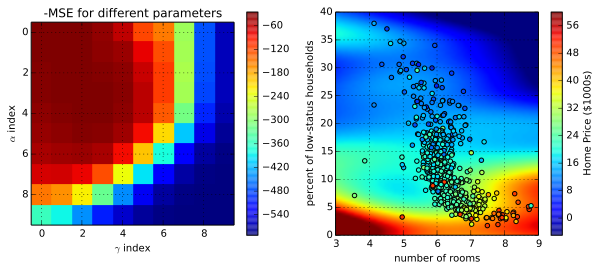

In [15]:
# predict 
xr = [linspace(bostonaxbox2[0],bostonaxbox2[1],100), 
      linspace(bostonaxbox2[2],bostonaxbox2[3],100)]
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

ypred = krr.predict(allpts).reshape(xgrid0.shape)

# extract the grid scores
avgscores = empty((len(params['alpha']), len(params['gamma'])))
for z in krr.grid_scores_:
    # get index
    i = where(params['alpha'] == z.parameters['alpha']) 
    j = where(params['gamma'] == z.parameters['gamma'])
    avgscores[i,j] = z.mean_validation_score

# show MSE scores for cross validation
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(avgscores, interpolation='nearest')
plt.ylabel('$\\alpha$ index')
plt.xlabel('$\\gamma$ index')
plt.grid(True)
plt.title('-MSE for different parameters')
plt.colorbar()

# show regression function
vmin = bostonY.min()-10
vmax = bostonY.max()+10
plt.subplot(1,2,2)
plt.imshow(ypred, origin='lower', extent=bostonaxbox2, aspect='auto', 
           vmin=vmin, vmax=vmax)
plt.scatter(bostonX[:,0], bostonX[:,1], c=bostonY, vmin=vmin, vmax=vmax)
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms')
plt.ylabel('percent of low-status households')
plt.grid(True); plt.axis(bostonaxbox2);

# Support Vector Regression (SVR)
- Suppose we form a "band" of width $\epsilon$ around the function:
  - if a point is inside, then it is "correctly" predicted
  - if a point is outside, then it is incorrectly predicted

In [16]:
epsilon = 11.5
svr = svm.SVR(C=1000, kernel='linear', epsilon=epsilon)
svr.fit(linX, linY)

axbox = [-3, 3, -50, 100]
xr = linspace(axbox[0], axbox[1], 100).reshape(100,1)
ypred = svr.predict(xr)

svrfig = plt.figure()
l1, = plt.plot(linX, linY, 'b.')
l2, = plt.plot(xr, ypred, 'r-')
l3, = plt.plot(xr, ypred+epsilon, 'r--')
plt.plot(xr, ypred-epsilon, 'r--')
plt.grid(True); plt.axis(axbox)
leg = plt.legend((l2, l3), ('$f(x)$', '$f(x)\\pm\\epsilon$'), loc='lower right')
leg.get_frame().set_facecolor('white')
plt.title('$\\epsilon=11.5$');
plt.close()

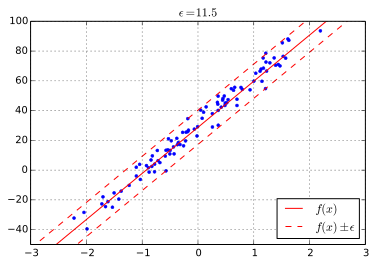

In [17]:
svrfig

- Allow some points to be outside the "tube".
  - penalty of point outside tube is controlled by $C$ parameter.
- SVR objective function:
$$\min_{w,b} \sum_{i=1}^N \left|y_i - (w^Tx_i+b)\right|_{\epsilon} + \frac{1}{C}||w||^2$$

- epsilon-insensitive error:
  - $\left|z\right|_{\epsilon} = \begin{cases} 0, & |z|\leq \epsilon \\ |z|-\epsilon, & z\gt \epsilon\end{cases}$
- Similar to SVM classifier, the points on the band will be the _support vectors_ that define the function.

# Different tube widths

In [18]:
axbox = [-3, 3, -50, 100]
xr = linspace(axbox[0], axbox[1], 100).reshape(100,1)
svrfig = plt.figure(figsize=(10,6))

ind = 1
for C in [1,10]:
    for epsilon in [5,10,25]:
        svr = svm.SVR(C=C, kernel='linear', epsilon=epsilon)
        svr.fit(linX, linY)

        ypred = svr.predict(xr)
        ss = svr.support_   # get support vector indicies
    
        plt.subplot(2,3,ind)
        l1, = plt.plot(linX, linY, 'b.')
        l2, = plt.plot(xr, ypred, 'r-')
        l3, = plt.plot(xr, ypred+epsilon, 'r--')
        plt.plot(xr, ypred-epsilon, 'r--')
        l4, = plt.plot(linX[ss], linY[ss], 'r.')
        plt.grid(True); plt.axis(axbox)
        if (C==1):
            plt.title('$\\epsilon='+str(epsilon)+"$")
        if (epsilon==5):
            plt.ylabel('C='+str(C))
        if (ind==1):
            leg = plt.legend((l1, l2, l3, l4), 
                       ('points', '$f(x)$', '$f(x)\\pm\\epsilon$', 'support vectors'),
                      fontsize=7, loc='upper left')
            leg.get_frame().set_facecolor('white')
        ind=ind+1
plt.close()

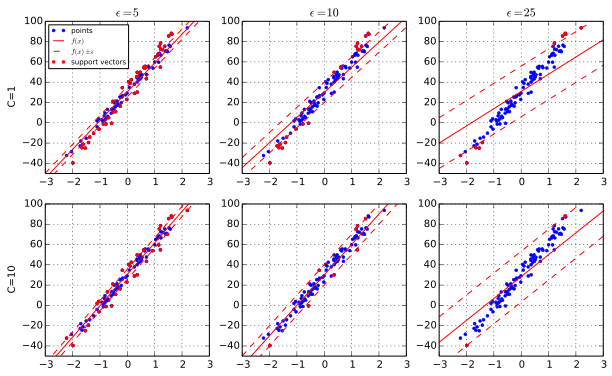

In [19]:
svrfig

# Kernel SVR
- Support vector regression can also be kernelized similar to SVM
  - turn linear regression to non-linear regression
- Polynomial Kernel:

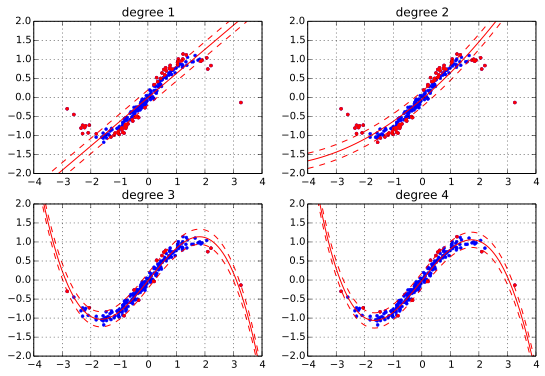

In [20]:
plt.figure(figsize=(9,6))

axbox = [-4, 4, -2, 2]
xr = linspace(axbox[0], axbox[1], 100)[:,newaxis]
epsilon = 0.2

for d in [1,2,3,4]:
    # fit the parameters (poly SVR)
    svr = svm.SVR(C=1000, kernel='poly', coef0=0.1, degree=d, epsilon=epsilon)
    svr.fit(polyX, polyY)
    
    # predict the function
    Ypred = svr.predict(xr)
    # support vector indicies
    ss = svr.support_
    
    plt.subplot(2,2,d)
    plt.plot(polyX, polyY, 'b.')
    plt.plot(polyX[ss], polyY[ss], 'r.')
    plt.plot(xr, Ypred, 'r-')
    plt.plot(xr, Ypred+epsilon, 'r--')
    plt.plot(xr, Ypred-epsilon, 'r--')
    plt.axis(axbox); plt.grid(True)
    plt.title("degree " + str(d))

# SVR with RBF kernel

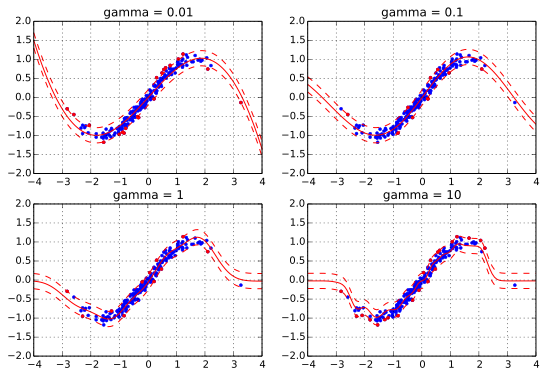

In [21]:
plt.figure(figsize=(9,6))

axbox = [-4, 4, -2, 2]
xr = linspace(axbox[0], axbox[1], 100)[:,newaxis]
epsilon = 0.2

for i,g in enumerate([0.01, 0.1, 1, 10]):

    # fit the parameters: SVR with RBF
    svr = svm.SVR(C=1000, kernel='rbf', gamma=g, epsilon=epsilon)
    svr.fit(polyX, polyY)
    
    # predict the function
    Ypred = svr.predict(xr)
    # support vector indicies
    ss = svr.support_
    
    plt.subplot(2,2,i+1)
    plt.plot(polyX, polyY, 'b.')
    plt.plot(polyX[ss], polyY[ss], 'r.')
    plt.plot(xr, Ypred, 'r-')
    plt.plot(xr, Ypred+epsilon, 'r--')
    plt.plot(xr, Ypred-epsilon, 'r--')
    plt.axis(axbox); plt.grid(True)
    plt.title("gamma = " + str(g))

# Boston Data
- Cross-validation to select 3 parameters
  - C, $\gamma$, $\epsilon$

In [22]:
# parameters for cross-validation
params = {'C':     logspace(-3,3,10),
          'gamma': logspace(-3,3,10),
          'epsilon': logspace(-2,2,10)}

# do cross-validation with grid_search module.
svr = grid_search.GridSearchCV(
    svm.SVR(kernel='rbf'),  # estimator
    params,                                  # parameters to try
    scoring='mean_squared_error',          # score function
    cv=5, verbose=1)             
svr.fit(bostonX, bostonY)

print svr.best_score_
print svr.best_params_


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:   16.5s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:   22.3s
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed:   32.5s
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed:   50.5s


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
-23.8368717747
{'epsilon': 1.6681005372000592, 'C': 215.44346900318823, 'gamma': 0.021544346900318832}


[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  2.1min finished


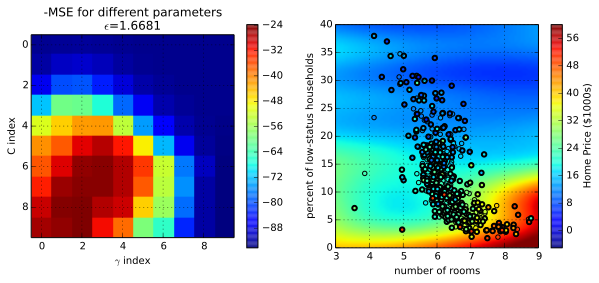

In [23]:
# predict 
xr = [linspace(bostonaxbox2[0],bostonaxbox2[1],100), 
      linspace(bostonaxbox2[2],bostonaxbox2[3],100)]
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

ypred = svr.predict(allpts).reshape(xgrid0.shape)
ss = svr.best_estimator_.support_   # get support vector indicies from best model


# extract the grid scores for visualization
avgscores = empty((len(params['C']), len(params['gamma']), len(params['epsilon'])))
for z in svr.grid_scores_:
    # get index
    i = where(params['C'] == z.parameters['C']) 
    j = where(params['gamma'] == z.parameters['gamma'])
    k = where(params['epsilon'] == z.parameters['epsilon'])
    avgscores[i,j,k] = z.mean_validation_score
bestie = where(params['epsilon'] == svr.best_params_['epsilon'])[0][0]

# show MSE scores for cross validation
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(avgscores[:,:,bestie], interpolation='nearest')
plt.ylabel('C index')
plt.xlabel('$\\gamma$ index')
plt.grid(True)
plt.title('-MSE for different parameters\n$\\epsilon$=%0.5g' % (svr.best_params_['epsilon'],))
plt.colorbar()

# show regression function
vmin = bostonY.min()-10
vmax = bostonY.max()+10
plt.subplot(1,2,2)
plt.imshow(ypred, origin='lower', extent=bostonaxbox2, aspect='auto', 
           vmin=vmin, vmax=vmax)
plt.scatter(bostonX[:,0], bostonX[:,1], c=bostonY, vmin=vmin, vmax=vmax)
plt.scatter(bostonX[ss,0], bostonX[ss,1], c=bostonY[ss], vmin=vmin, vmax=vmax, lw=2)
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms')
plt.ylabel('percent of low-status households')
plt.grid(True); plt.axis(bostonaxbox2);

# Regression Summary
- **Goal:** predict output $y\in\mathbb{R}$ from input $x\in\mathbb{R}^d$.
  - i.e., learn the function $y = f(x)$.

<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Function</th>
<th>Training</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>Ordinary Least Squares</td>
<td>linear</td>
<td>minimize square error between observation and predicted output.</td>
<td>- closed-form solution.</td>
<td>- sensitive to outliers and overfitting.</td>
</tr>
<tr>
<td>ridge regression</td>
<td>linear</td>
<td>minimize squared error with $||w||^2$ regularization term.</td>
<td>- closed-form solution;<br>- shrinkage to prevent overfitting.</td>
<td>- sensitive to outliers.</td>
</tr>
<tr>
<td>LASSO</td>
<td>linear</td>
<td>minimize squared error with $\sum_{j=1}^d|w_j|$ regularization term.</td>
<td>- feature selection (by forcing weights to 0)</td>
<td>- sensitive to outliers.</td>
</tr>
<tr>
<td>RANSAC</td>
<td>same as the base model</td>
<td>randomly sample subset of training data and fit model; keep model with most inliers.</td>
<td>- ignores outliers.</td>
<td>- requires enough iterations to find good consensus set.</td>
</tr>
<tr>
<td>kernel ridge regression</td>
<td>non-linear (kernel function)</td>
<td>apply "kernel trick" to ridge regression.</td>
<td>- non-linear regression. <br>- Closed-form solution.</td>
<td>- requires calculating kernel matrix $O(N^2)$.<br>- cross-validation to select hyperparameters.</td>
</tr>
<tr>
<td>kernel support vector regression</td>
<td>non-linear (kernel function)</td>
<td>minimize squared error, insensitive to epsilon-error.</td>
<td>- non-linear regression.<br>- faster predictions than kernel ridge regression.</td>
<td>- requires calculating kernel matrix $O(N^2)$.<br>- iterative solution (slow).<br>- cross-validation to select hyperparameters.</td>
</tr>
</table>

# Other Things
- _Feature normalization_
  - feature normalization is typically required for regression methods with regularization.
  - makes ordering of weights more interpretable (LASSO, RR).
- _Output transformations_
  - sometimes the output values have a large dynamic range (e.g., $10^-1$ to $10^5$).
    - large output values will have large error, which will dominate the training error.
  - in this case, it is better to transform the output values using the logarithm function.
    - $\hat{y} = \log_{10} (y)$
  - For example, see the tutorial.